In [4]:
from lib.HK.header_notebook import *
import lib.HK.OTCommon as OTCommon
import lib.HK.SinkhornNP as Sinkhorn
import lib.HK.LinHK as LinHK
import lib.HK.LinW2 as LinW2
import lib.HK.Tools as Tools
from scipy import sparse


import torch
import numpy as np 
import os
import sys
import numba as nb
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import time
from sklearn.datasets import make_swiss_roll, make_moons, make_circles
import ot


import torch


os.chdir('/home/baly/projects/linear_opt')


%matplotlib inline

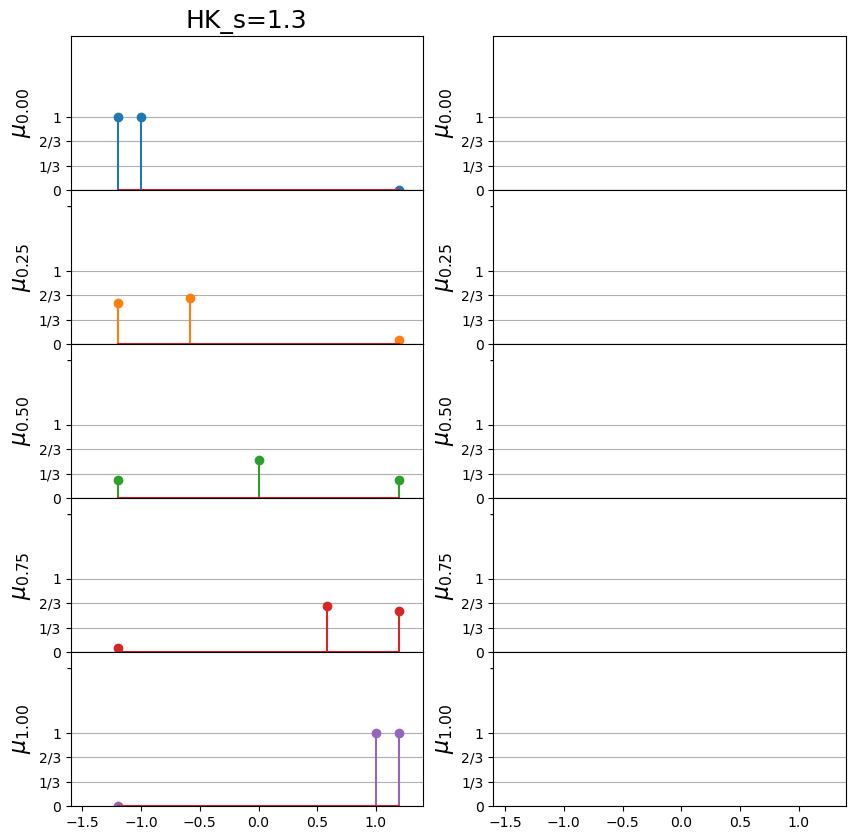

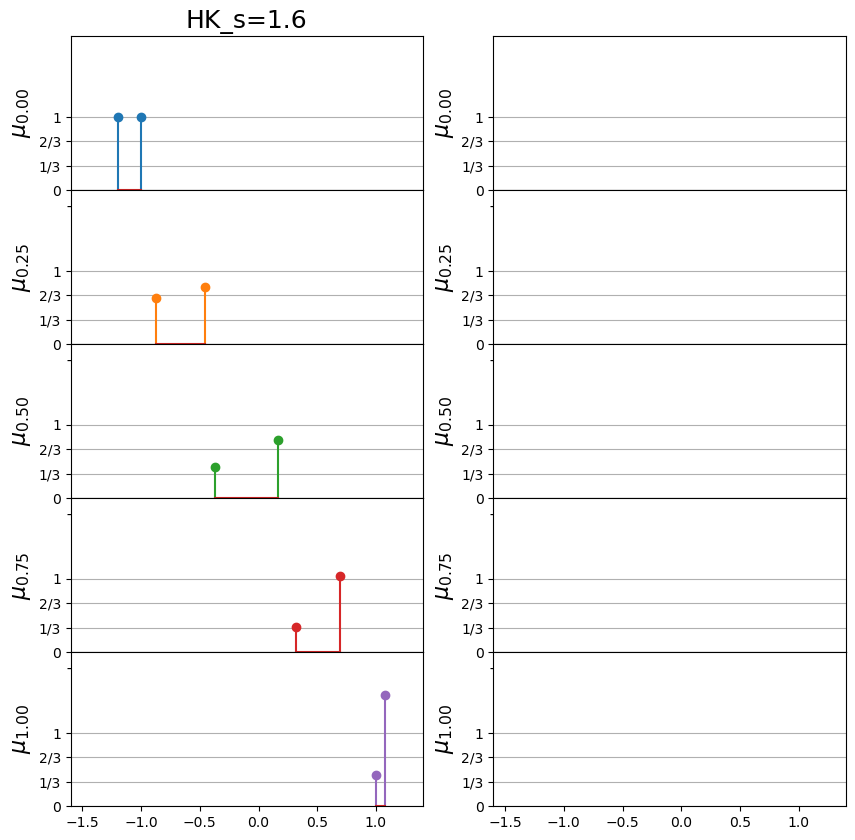

In [7]:
setup_HKScale_list=[1.3,1.6]
Lambda_list=[2.5,5.0]

posmu = np.array([[-1.2],[-1]])
mu = np.array([1,1])
posNu = np.array([[1],[1.2]])
nu = np.array([1, 1])
K=5
for setup_HKScale,Lambda in zip(setup_HKScale_list,Lambda_list):
    
    
    # HK start 
    tList=np.linspace(0,1,K)
    fig,ax=plt.subplots(K,2,figsize=(10,10))
    # solve HK 
    params={}
    params["setup_HKMode"]=True
    params["setup_HKScale"]=setup_HKScale
    params["solver_errorGoal"]=1.E-4
    params["aux_verbose"]=False
    params["solver_epsStart"]=1E3*setup_HKScale/1.3 
    params["solver_epsTarget"]=0.1*setup_HKScale/1.3 

    # solve HK transport
    value,pi=Sinkhorn.SolveHK(mu,posmu,nu,posNu,HKScale=params["setup_HKScale"],
            SinkhornError=params["solver_errorGoal"],
            epsTarget=params["solver_epsTarget"], epsInit=params["solver_epsStart"],
            returnSolver=False
            )

    # from optimal coupling compute tangent vector data
    u0,u1,x1,muPerp,nuPerp=LinHK.extractMongeData(pi,mu,nu,posNu)
    v0,alpha0=LinHK.HKLog(posmu,u0,x1,u1,params["setup_HKScale"])
    
    # HK end 
    
    # Solve OPT
    u0_opt,p0_opt,M_opt,nuPerp=lopt_embedding(posmu,posNu,mu,nu,Lambda)
    #u1_opt,p1_opt,M1_opt=lopt_embedding(posNu,posmu,nu,mu,Lambda)
    
    Xt_list,pt,X_d,p_d=opt_interpolation(posmu,u0_opt,mu,p0_opt,tList)   # (X0,U1,p0,p1_hat,t_list)
    X_c=posNu[nuPerp>0]
    p_c=nuPerp[nuPerp>0]
    #p_c=opt_interpolation(posNu,u1_opt,nu,p1_opt,np.array([0.]))
    

    for j in range(2):
        for i,t in enumerate(tList):
            # shoot averaged tangent vector back to a measure
            s='C%d-'%i
            if j==0:
                # HK start 
                expmu,expT=LinHK.HKExp(mu,posmu,t*v0,t*alpha0,HKScale=params["setup_HKScale"])
                expT=np.concatenate([expT,posNu[nuPerp>0]]) 
                expmu=np.concatenate([expmu,nuPerp[nuPerp>0]*t**2])
                # HK end 
               # result['HK-'+str(setup_HKScale)].append((expT,expmu))   
                if i==0: 
                    ax[i,j].set_title('HK_s='+str(setup_HKScale),fontsize=18)
                ax[i,j].stem(expT,expmu,s)
                
#             else:
#                 expT=np.concatenate([Xt_list[i],X_d,X_c])
#                 expmu=np.concatenate([pt,(1-t)*p_d,t*p_c])
#                 #result['OPT-'+str(Lambda)].append((expT,expmu))
#                 if i==0:
#                     ax[i,j].set_title('OPT_$\lambda=$'+str(Lambda),fontsize=18)
  


            ax[i,j].set_xlim([-1.6,1.4])
            ax[i,j].set_ylim([0,2.1])
            ax[i,j].set_ylabel(r'$\mu_{%0.2f}$'%t,fontsize=16)
            ax[i,j].grid(True,axis='y')
            ax[i,j].set_yticks([0,1/3,2/3,1])
            ax[i,j].set_yticklabels(['0','1/3','2/3','1'])
            # if i not in [0,4]:
            #     ax[i,j].tick_params(left = False, right = False , labelleft = False ,
            #         labelbottom = False, bottom = False)
        plt.subplots_adjust( hspace=0)
    #plt.savefig('experiment/Fig1/comparisonHK_%0.2f.pdf'%(params["setup_HKScale"]),bbox_inches='tight')
#torch.save(result,'experiment/Fig1/result_1d.pt')

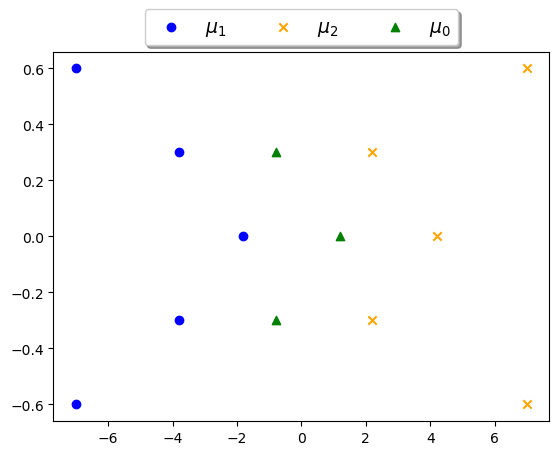

In [18]:
Tri=np.array(
[[-0.8,0.3],
[-0.8,-0.3],
[1.2,0]],dtype=np.float64)
Noise=np.array(
[[-4,0.6],
[-4,-0.6]],dtype=np.float64)

X0=Tri
mu0=np.ones(3)

X1=np.concatenate((Tri,Noise))
X1[:,0]-=3
mu1=np.ones(5)

X2=np.concatenate((Tri,Noise))
X2[:,0]+=3
X2[3:5,0]+=8

mu2=np.ones(5)

plt.scatter(X1[:,0],X1[:,1],c='blue',marker='o',label='$\mu_1$')
plt.scatter(X2[:,0],X2[:,1],c='orange',marker='x',label='$\mu_2$')
plt.scatter(X0[:,0],X0[:,1],c='green',marker='^',label='$\mu_0$')
#plt.scatter(X2[:,0],X2[:,1],c='orange',marker='x')
plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.14),
          fancybox=True, shadow=True, ncol=3,fontsize=13.6)
plt.savefig('experiment/Rebuttal/A1_data.png',bbox_inches='tight')

plt.show()

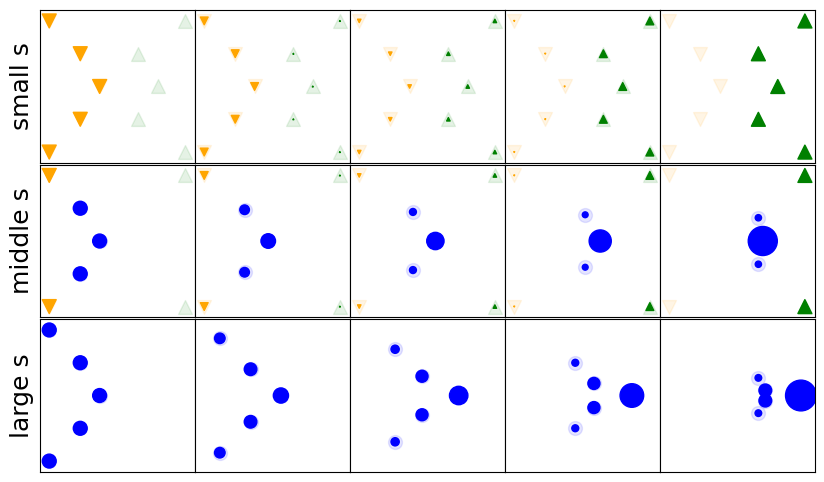

In [17]:
setup_HKScale_list=np.array([1.2, 5.2, 10.6])
K0=setup_HKScale_list.shape[0]
key_list=['small','middle','large']
K=5
tList=np.linspace(0,1,K)
fig,ax=plt.subplots(K0,K,figsize=(2*K,K0*2))

scaling=100


for (setup_HKScale,key,i) in zip(setup_HKScale_list,key_list,range(K0)):
    # Do HK interporlation
    params={}
    params["setup_HKMode"]=True
    params["setup_HKScale"]=setup_HKScale
    params["solver_errorGoal"]=1e-4
    params["aux_verbose"]=False
    params["solver_epsStart"]=1e3*setup_HKScale/1.3 
    params["solver_epsTarget"]=0.1*setup_HKScale/1.3 

    value,gamma=Sinkhorn.SolveHK(mu1,X1,mu2,X2,HKScale=params["setup_HKScale"],
    SinkhornError=params["solver_errorGoal"],
    epsTarget=params["solver_epsTarget"], epsInit=params["solver_epsStart"],
    returnSolver=False
    )
    u0,u1,x1,muPerp,nuPerp=LinHK.extractMongeData(gamma,mu1,mu2,X2)
    v0,alpha0=LinHK.HKLog(X1,u0,x1,u1,params["setup_HKScale"])
        
    for j,t in enumerate(tList):
        # shoot averaged tangent vector back to a measure
        mu_a,X_a=LinHK.HKExp(mu1,X1,t*v0,t*alpha0,HKScale=params["setup_HKScale"])
        D=np.sum(v0**2,1)>1e-10
        mu_t=mu_a[D]
        mu_d=mu_a[np.invert(D)]
        X_t=X_a[D]
        X_d=X_a[np.invert(D)]
        X_c=X2[nuPerp>0]
        mu_c=nuPerp[nuPerp>0]*t**2
        if mu_t.shape[0]>0:
            ax[i,j].scatter(X_t[:,0],X_t[:,1],s=mu_t**2*scaling,color='blue',marker='o')
            ax[i,j].scatter(X_t[:,0],X_t[:,1],s=1*scaling,color='blue',marker='o',alpha=0.1)
        if mu_d.shape[0]>0:
            ax[i,j].scatter(X_d[:,0],X_d[:,1],s=mu_d**2*scaling,color='orange',marker='v')
            ax[i,j].scatter(X_d[:,0],X_d[:,1],s=1*scaling,color='orange',marker='v',alpha=0.1)
        if mu_c.shape[0]>0:
            ax[i,j].scatter(X_c[:,0],X_c[:,1],s=mu_c**2*scaling,color='green',marker='^')
            ax[i,j].scatter(X_c[:,0],X_c[:,1],s=1*scaling,color='green',marker='^',alpha=0.1)
        ax[i,j].set_xlim([-8,8])
        ax[i,j].set_ylim([-0.7,0.7])
        ax[i,j].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
        if j==0:
            ax[i,j].set_ylabel(key+' s',rotation=90,fontsize=18)
        # add text to left side of figure

plt.subplots_adjust(wspace=0, hspace=0.01) 
plt.show()

#torch.save(result,'experiment/Fig1/result_2d.pt')


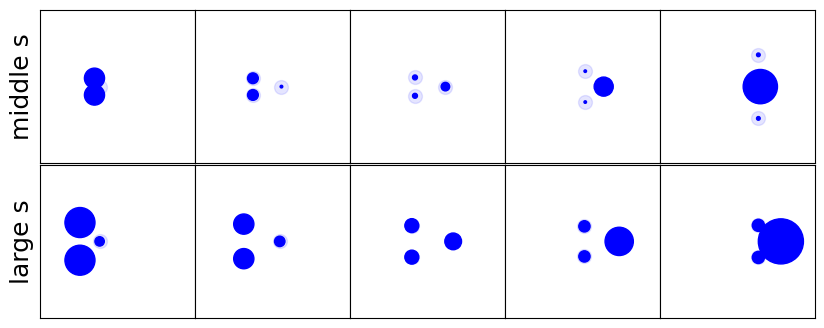

In [20]:
setup_HKScale_list=np.array([2.5, 5.0])
Lambda_list=np.array([20, 80])
K0=setup_HKScale_list.shape[0]
key_list=['middle','large']

K=5
tList=np.linspace(0,1,K)
fig,ax=plt.subplots(K0,K,figsize=(2*K,K0*2))


for (setup_HKScale,key,i) in zip(setup_HKScale_list,key_list,range(K0)):
    # Do HK interporlation
    params={}
    params["setup_HKMode"]=True
    params["setup_HKScale"]=setup_HKScale
    params["solver_errorGoal"]=1e-4
    params["aux_verbose"]=False
    params["solver_epsStart"]=1e3*setup_HKScale/1.3 
    params["solver_epsTarget"]=0.1*setup_HKScale/1.3 
    
    value,gamma=Sinkhorn.SolveHK(mu0,X0,mu1,X1,HKScale=params["setup_HKScale"],
            SinkhornError=params["solver_errorGoal"],
            epsTarget=params["solver_epsTarget"], epsInit=params["solver_epsStart"],
            returnSolver=False)
        

    # from optimal coupling compute tangent vector data
    u0_1,u1_1,x1_1,muPerp_1,nuPerp_1=LinHK.extractMongeData(gamma,mu0,mu1,X1)
    v0_1,alpha0_1=LinHK.HKLog(X0,u0_1,x1_1,u1_1,params["setup_HKScale"])
    
    
    value,gamma=Sinkhorn.SolveHK(mu0,X0,mu2,X2,HKScale=params["setup_HKScale"],
            SinkhornError=params["solver_errorGoal"],
            epsTarget=params["solver_epsTarget"], epsInit=params["solver_epsStart"],
            returnSolver=False
            )

    u0_2,u1_2,x1_2,muPerp_2,nuPerp_2=LinHK.extractMongeData(gamma,mu0,mu2,X2)
    v0_2,alpha0_2=LinHK.HKLog(X0,u0_2,x1_2,u1_2,params["setup_HKScale"])

       
        
    for j,t in enumerate(tList):
        # shoot averaged tangent vector back to a measure
        v0_t=(1-t)*v0_1+t*v0_2
        alpha0_t=(1-t)*alpha0_1+t*alpha0_2
        mu_a,X_a=LinHK.HKExp(mu0,X0,v0_t,alpha0_t,HKScale=params["setup_HKScale"])
        D=np.sum(v0_t**2,1)>1e-10
        mu_t=mu_a[D]
        mu_d=mu_a[np.invert(D)]
        X_t=X_a[D]
        X_d=X_a[np.invert(D)]
        #X_c=X2[nuPerp>0]
        #mu_c=nuPerp[nuPerp>0]*t**2
        if mu_t.shape[0]>0:
            ax[i,j].scatter(X_t[:,0],X_t[:,1],s=mu_t**2*scaling,color='blue',marker='o')
            ax[i,j].scatter(X_t[:,0],X_t[:,1],s=1*scaling,color='blue',marker='o',alpha=0.1)
        if mu_d.shape[0]>0 and np.sum(mu_d)>0:
            ax[i,j].scatter(X_d[:,0],X_d[:,1],s=mu_d**2*scaling,color='orange',marker='v')
            ax[i,j].scatter(X_d[:,0],X_d[:,1],s=1*scaling,color='orange',marker='v',alpha=0.1)
        #if mu_c.shape[0]>0:
        #    ax[i,j].scatter(X_c[:,0],X_c[:,1],s=mu_c**2*scaling,color='green',marker='^')
        #    ax[i,j].scatter(X_c[:,0],X_c[:,1],s=1*scaling,color='green',marker='^',alpha=0.1)
        ax[i,j].set_xlim([-8,8])
        ax[i,j].set_ylim([-0.7,0.7])
        ax[i,j].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
        if j==0:
            ax[i,j].set_ylabel(key+' s',rotation=90,fontsize=18)
        # add text to left side of figure

    

plt.subplots_adjust(wspace=0, hspace=0.01)

plt.show()

#torch.save(result,'experiment/Fig1/result_2d.pt')
